# Day 41 · Dataset 与 DataLoader


在训练大规模数据集时，显存通常无法一次性装下所有样本，因此必须按批次把数据送入模型。PyTorch 为此提供了两个密不可分的组件：

1. **`Dataset`**：描述每一条数据长什么样、如何读取、是否需要预处理。
2. **`DataLoader`**：负责把一个 `Dataset` 切成批次、决定是否乱序、是否并行加载。

下面以经典的 **MNIST 手写数字** 数据集为例（训练集 60k、测试集 10k、每张 28×28 灰度图），逐步梳理两者分工。


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 为可复现性固定随机种子
torch.manual_seed(42)


### torchvision 模块速览

```
torchvision
├── datasets       # 视觉数据集（如 MNIST、CIFAR）
├── transforms     # 视觉数据预处理（裁剪、翻转、归一化等）
├── models         # 各类预训练模型
├── utils          # 目标检测等常用工具函数
└── io             # 图像 / 视频 IO
```


### Step 1 · 定义 `transforms` 管道
`transforms.Compose` 可以像数据管道一样串联多步操作，这里先把 PIL 图转成张量，再用 MNIST 的均值、方差做标准化。


In [2]:
# 1. 数据预处理，该写法非常类似于管道pipeline
# transforms 模块提供了一系列常用的图像预处理操作

# 先归一化，再标准化
transform = transforms.Compose([
    transforms.ToTensor(), # 转换为张量并归一化到[0,1]
    transforms.Normalize((0.1307,), (0.3081,)) # 标准化。MNIST数据集的均值和标准差，这个值很出名，所以直接使用
])


In [3]:
# Step 2 · 加载数据集。如果本地没有，会自动下载到 ./data
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform
)


100%|██████████| 9.91M/9.91M [00:07<00:00, 1.37MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 152kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.70MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.8MB/s]


> PyTorch 的思路是：**在“读取数据”这一环就完成预处理**，因此 `transform` 直接写进 `datasets.MNIST` 的构造函数里。


## 一、Dataset：定义“单份数据”
- 负责描述数据的来源、存储方式以及取出单个样本所需的所有步骤。
- 必须能够在索引访问时返回 `(features, target)`，并能报告自身的长度。


### 1. 先拿出一张看看
`Dataset` 实例支持下标操作，因此可以像访问列表一样通过索引获取单张图像及其标签。


In [4]:
# 随机选择一张图片，可以重复运行，每次都会随机选择
sample_idx = torch.randint(0, len(train_dataset), size=(1,)).item() # 随机选择一张图片的索引
# len(train_dataset) 表示训练集的图片数量；size=(1,)表示返回一个索引；torch.randint() 函数用于生成一个指定范围内的随机数,item() 方法将张量转换为 Python 数字
image, label = train_dataset[sample_idx] # 获取图片和标签

### 2. 两个必须的魔术方法
`torch.utils.data.Dataset` 是一个抽象基类，自定义数据集需要重写：

- `__len__()`：返回样本总数，供 `len(dataset)` 或 DataLoader 计算迭代次数。
- `__getitem__(idx)`：根据索引返回单个样本（通常是 `(data, label)`）。

因此 `train_dataset[sample_idx]` 才会得到 `(image, label)`。


#### `__getitem__`：让对象支持索引


In [5]:
class MyList:  # 仅为解释魔术方法的示例
    def __init__(self):
        self.data = [10, 20, 30, 40, 50]

    def __getitem__(self, idx):
        return self.data[idx]

my_list_obj = MyList()
print(my_list_obj[2])  # 输出 30


30


#### `__len__`：让对象支持 `len()`


In [6]:
class MyList:
    def __init__(self):
        self.data = [10, 20, 30, 40, 50]

    def __len__(self):
        return len(self.data)

my_list_obj = MyList()
print(len(my_list_obj))  # 输出 5


5


### 3. 自定义 `Dataset` 的伪代码
常见写法是在构造函数中读入路径或内存数据，并保存 `transform`；`__getitem__` 返回预处理后的样本。


In [7]:
class MNIST(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.data, self.targets = fetch_mnist_data(root, train)  # 假设这里完成原始数据读取
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, target = self.data[idx], self.targets[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, target


| 组件             | 职责                                                      | 关键方法                              |
| -------------- | ------------------------------------------------------- | --------------------------------- |
| **Dataset**    | 1. 存储数据和标签的映射关系<br>2. 定义单样本的获取方式<br>3. 应用样本级预处理（如缩放、裁剪） | `__getitem__(idx)`<br>`__len__()` |
| **DataLoader** | 1. 批量组织样本<br>2. 并行加载数据<br>3. 打乱数据顺序<br>4. 处理多进程问题       | 迭代器接口（`iter()` 和 `next()`）        |



- 可以把 **Dataset 想成“厨师”**：负责挑选食材、清洗、调味（预处理）。
- **DataLoader 则像“服务员”**：按订单把菜（批次）端给模型。


Label: 6


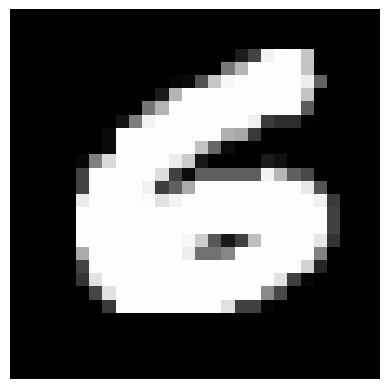

In [8]:
def imshow(img):
    img = img * 0.3081 + 0.1307  # 反标准化回原始像素
    npimg = img.numpy()
    plt.imshow(npimg[0], cmap='gray')
    plt.axis('off')
    plt.show()

print(f"Label: {label}")
imshow(image)


## 二、DataLoader：批量调度器
DataLoader 根据我们提供的 `Dataset` 产出一个可迭代对象，它负责：

- 按 `batch_size` 聚合样本；
- 根据 `shuffle` 决定是否随机打乱顺序；
- 通过 `num_workers` 控制并行加载进程数。


In [9]:
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)


test_loader = DataLoader(
    test_dataset,
    batch_size=1000
    # 测试集通常不需要 shuffle
)


## 三、速记总结


| **维度** | **Dataset** | **DataLoader** |
|---|---|---|
| 核心职责 | 定义“数据是什么”以及如何得到单个样本 | 决定怎样批量、按顺序或乱序地取数据 |
| 核心接口 | `__getitem__`、`__len__` | 通过参数控制加载逻辑，无需继承 |
| 预处理 | 在 `__getitem__` 或 `transform` 中完成 | 不做预处理，直接消费 Dataset 的输出 |
| 并行能力 | 单线程读取 | `num_workers>0` 时可多进程读取 |
| 典型参数 | `root`、`transform`、`target_transform` | `batch_size`、`shuffle`、`num_workers` |

